In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error as mse

import itertools as it

import warnings
warnings.filterwarnings('ignore')

## load data

In [ ]:
files.upload()

In [3]:
df = pd.read_excel('emass.xlsx', parse_dates=['Date'])

## data understanding

In [4]:
df.shape, df.isna().sum()

((1258, 7),
 Date      0
 Open      0
 High      0
 Low       0
 Close     0
 Adj       0
 Volume    0
 dtype: int64)

In [5]:
df.info(), df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Adj     1258 non-null   float64       
 6   Volume  1258 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.9+ KB


(None,
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj', 'Volume'], dtype='object'))

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj,Volume
0,2023-11-10,1959.6,1959.6,1932.6,1932.6,1932.6,10
1,2023-11-09,1951.7,1964.2,1945.3,1964.2,1964.2,10
2,2023-11-08,1967.8,1967.8,1947.7,1951.5,1951.5,43
3,2023-11-07,1966.5,1966.8,1960.7,1966.8,1966.8,20
4,2023-11-06,1981.6,1981.6,1977.4,1981.6,1981.6,130


## data preparation

In [7]:
df = df.sort_values('Date')

In [8]:
df['stationer'] = df['Close'].diff()
df.dropna(inplace=True)

In [9]:
data = df[['Date', 'Close']].set_index('Date')

<Axes: xlabel='Date'>

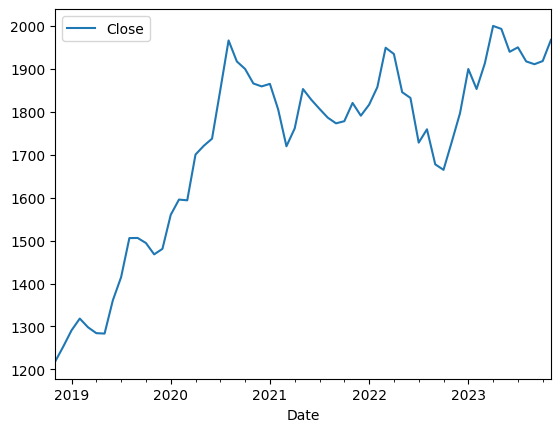

In [10]:
data = data.resample('MS').mean()
data.plot()

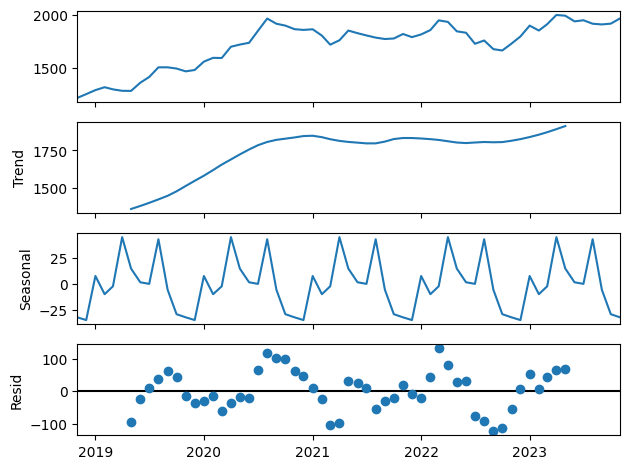

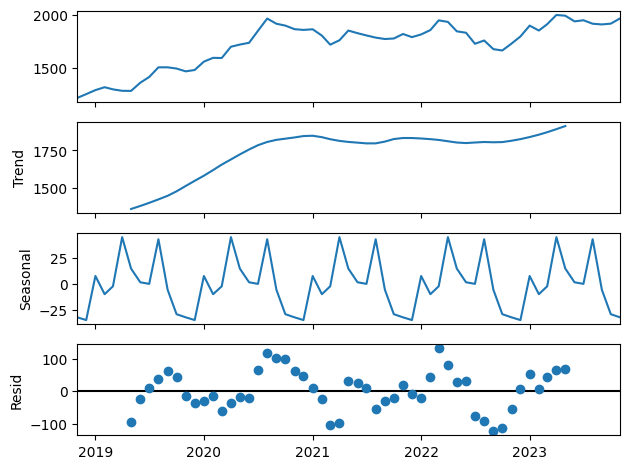

In [11]:
decomposed = seasonal_decompose(data, model='additive')
decomposed.plot()

## split train-test

In [12]:
data.shape

(61, 1)

In [14]:
train = data.iloc[:-12]
test = data.iloc[-12:] #20%

# Modelling

In [24]:
p = q = range(0, 3)
d = range(0,2)
pdq = list(it.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(pdq)]

In [25]:
jawab=[]
def get_param(data, param1, param2, iter):
    hasil = []
    for x in param1:
        for y in param2:
            try:
                mod = SARIMAX(data,
                              order = x,
                              seasonal_order = y,)
                hasil = mod.fit(maxiter=iter)
                jawab.append([x, y, hasil.aic.round(1)])
            except:
                continue

In [26]:
get_param(train, pdq, pdqs, 50)

In [27]:
dataparam = pd.DataFrame(jawab, columns=['param_order', 'param_seasonal', 'aic'])
dataparam = dataparam.sort_values(by = ['aic'],ascending=True)[:15]
dataparam

,param_order,param_seasonal,aic
228,"(2, 0, 0)","(2, 0, 1, 12)",12.0
76,"(0, 1, 1)","(0, 1, 1, 12)",409.5
165,"(1, 1, 0)","(0, 1, 1, 12)",410.0
87,"(0, 1, 1)","(2, 1, 0, 12)",411.0
58,"(0, 1, 0)","(0, 1, 1, 12)",411.2
77,"(0, 1, 1)","(0, 1, 2, 12)",411.2
82,"(0, 1, 1)","(1, 1, 1, 12)",411.3
273,"(2, 1, 0)","(0, 1, 1, 12)",411.4
94,"(0, 1, 2)","(0, 1, 1, 12)",411.5
176,"(1, 1, 0)","(2, 1, 0, 12)",411.5


In [28]:
order, season = dataparam["param_order"], dataparam["param_seasonal"]

In [29]:
order, season = order.unique(), season.unique()
len(order), len(season)

(7, 6)

In [30]:
error=[]
def get_error(data, param1, param2, iter):
    for x in param1:
        for y in param2:
            try:
                mod = SARIMAX(data,
                              order = x,
                              seasonal_order = y)
                hasil = mod.fit(maxiter=iter)
                predik = hasil.get_forecast(steps=12)
                prediction = hasil.predict(len(train), len(train) + len(test)-1)
                error.append([x, y, mse(test, prediction).round(1)])
                print(f'{x} x {y} : mse = {mse(test, prediction).round(1)}')
            except:
                continue

In [31]:
get_error(train, order, season, 50)

(2, 0, 0) x (2, 0, 1, 12) : mse = 3696107.6
(2, 0, 0) x (0, 1, 1, 12) : mse = 27367.2
(2, 0, 0) x (2, 1, 0, 12) : mse = 10502.1
(2, 0, 0) x (0, 1, 2, 12) : mse = 32394.6
(2, 0, 0) x (1, 1, 1, 12) : mse = 33413.2
(2, 0, 0) x (1, 1, 0, 12) : mse = 38427.7
(0, 1, 1) x (2, 0, 1, 12) : mse = 29178.6
(0, 1, 1) x (0, 1, 1, 12) : mse = 9974.1
(0, 1, 1) x (2, 1, 0, 12) : mse = 5830.1
(0, 1, 1) x (0, 1, 2, 12) : mse = 11905.5
(0, 1, 1) x (1, 1, 1, 12) : mse = 12046.3
(0, 1, 1) x (1, 1, 0, 12) : mse = 51460.9
(1, 1, 0) x (2, 0, 1, 12) : mse = 30225.8
(1, 1, 0) x (0, 1, 1, 12) : mse = 8206.3
(1, 1, 0) x (2, 1, 0, 12) : mse = 4506.4
(1, 1, 0) x (0, 1, 2, 12) : mse = 10536.9
(1, 1, 0) x (1, 1, 1, 12) : mse = 10506.1
(1, 1, 0) x (1, 1, 0, 12) : mse = 50818.4
(0, 1, 0) x (2, 0, 1, 12) : mse = 63491.5
(0, 1, 0) x (0, 1, 1, 12) : mse = 26262.3
(0, 1, 0) x (2, 1, 0, 12) : mse = 14728.1
(0, 1, 0) x (0, 1, 2, 12) : mse = 16353.4
(0, 1, 0) x (1, 1, 1, 12) : mse = 18965.5
(0, 1, 0) x (1, 1, 0, 12) : mse = 57

Text(0.5, 1.0, 'mse = 1886.8')

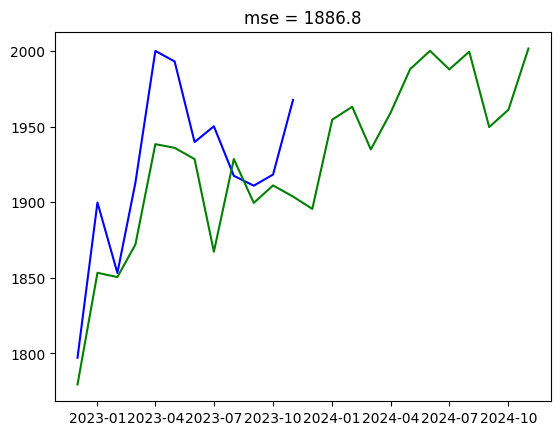

In [34]:
mod = SARIMAX(train,
              order = (2, 1, 2),
              seasonal_order = (2, 1, 0, 12))
output = mod.fit(maxiter=50)
predik = output.get_forecast(steps=12)
prediksi = output.predict(len(train), len(train) + len(test) +11)#.rename('Prediksi')
plt.plot(test,'b')
plt.plot(prediksi, 'g')
plt.title(f'mse = {mse(test, prediksi[:12]).round(1)}')

In [37]:
prediksi[12:].round(1)

2023-12-01    1895.6
2024-01-01    1954.7
2024-02-01    1963.2
2024-03-01    1934.9
2024-04-01    1959.5
2024-05-01    1988.0
2024-06-01    2000.2
2024-07-01    1987.9
2024-08-01    1999.7
2024-09-01    1949.8
2024-10-01    1961.3
2024-11-01    2001.8
Freq: MS, Name: predicted_mean, dtype: float64